# Long Short-Term Memory (LSTM)

In [1]:
import math
import pandas as pd
import numpy as np 
import tensorflow as tf
import warnings
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences


warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load Data

In [5]:
df_train = pd.read_csv('data/train_data.txt', header=None, delimiter=';')
df_test = pd.read_csv('data/test_data.txt', header=None, delimiter=';')

df_train = df_train.rename(columns= {0: 'text', 1: 'feeling'})
df_test = df_test.rename(columns= {0: 'text', 1: 'feeling'})

print(df_train.shape)
print(df_test.shape)

(16000, 2)
(2000, 2)


In [6]:
display(df_train.head(3))
display(df_test.head(3))

,text,feeling
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy


,text,feeling
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger
2,i feel like reds and purples are just so rich and kind of perfect,joy


> The column **text** is going to be the input feature and **feeling** is going to be the output target.

In [7]:
df_train['feeling'].value_counts()

feeling
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [8]:
df_test['feeling'].value_counts()

feeling
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

> The column **text** is going to be the input feature and **feeling** is going to be the output target.

## Data preprocessing using Spacy

[Oficial site](https://spacy.io/).

In [ ]:
!python -m spacy download en_core_web_md -q

In [9]:
# Load the dict
spacy_nlp = spacy.load('en_core_web_md')

In [10]:
def data_preprocessing(text):

    doc = spacy_nlp(text)

    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

    return ' '.join(tokens)

In [11]:
df_train['transformed_text'] = df_train['text'].apply(data_preprocessing)
df_test['transformed_text'] = df_test['text'].apply(data_preprocessing)

In [12]:
display(df_train.head())
display(df_test.head())

,text,feeling,transformed_text
0,i am feeling completely overwhelmed i have two strategies that help me to feel grounded pour my heart out in my journal in the form of a letter to god and then end with a list of five things i am most grateful for,fear,feel completely overwhelmed strategy help feel ground pour heart journal form letter god end list thing grateful
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your support and encouragement is a great feeling and i am so glad you were able to help me,joy,able help chai lifeline support encouragement great feeling glad able help
3,i already feel like i fucked up though because i dont usually eat at all in the morning,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed,sadness,love wish good long tolerate effect bm life fact turn bitter angry person particularly kind people feel stress


,text,feeling,transformed_text
0,i feel like my only role now would be to tear your sails with my pessimism and discontent,sadness,feel like role tear sail pessimism discontent
1,i feel just bcoz a fight we get mad to each other n u wanna make a publicity n let the world knows about our fight,anger,feel bcoz fight mad n u wanna publicity n let world know fight
2,i feel like reds and purples are just so rich and kind of perfect,joy,feel like red purple rich kind perfect
3,im not sure the feeling of loss will ever go away but it may dull to a sweet feeling of nostalgia at what i shared in this life with my dad and the luck i had to have a dad for years,sadness,m sure feeling loss away dull sweet feeling nostalgia share life dad luck dad year
4,i feel like ive gotten to know many of you through comments and emails and for that im appreciative and glad you are a part of this little space,joy,feel like ve get know comment email m appreciative glad little space


In [27]:
# Defining the tokenizer
tokenizer = Tokenizer()

# Adjusting the tokenizer with processed text
tokenizer.fit_on_texts(df_train['transformed_text'])

# Extracting words index
word_index = tokenizer.word_index

# Converting training texts to tokens sequence
train_seq = tokenizer.texts_to_sequences(df_train['transformed_text'])

# Defining sequence max length
max_lenght = 200

# Padding of training sequences
train_pad_seq = pad_sequences(train_seq, maxlen = max_lenght, truncating = 'post')

"**Padding**" is a technique commonly used in sequence data processing, especially in natural language processing (NLP) tasks. Padding is used to standardize the length of sequences. This is done by adding a special value (usually 0) at the beginning or the end of the sequences to extend them to a defined maximum length. This allows the model to process batches of sequences simultaneously, which is essential for training efficiency.

In the line above:

**maxlen = max_length**: This argument defines the maximum length of the sequences after padding. If a sequence is shorter than max_length, it will be extended with zeros until it reaches this length. If it is longer, it will be truncated.

**truncating = 'post'**: This argument specifies how sequences should be truncated to the maximum length if they are longer than max_length. The value 'post' indicates that truncation should occur at the end of the sequence. Alternatively, 'pre' would truncate at the beginning.

The result, `sequencias_treino_padded`, will be a matrix where each sequence has exactly max_length elements, with zeros added as padding where necessary. This makes the sequences compatible with many machine learning models, especially those used in NLP.

In [28]:
test_seq = tokenizer.texts_to_sequences(df_test['transformed_text'])

test_pad_seq = pad_sequences(test_seq, maxlen = max_lenght)

In [30]:
# Definig Label Encoder
le = LabelEncoder()

# Fit and transform labels to training
y_train_le = le.fit_transform(df_train['feeling'])
y_test_le = le.transform(df_test['feeling'])

# Converting to categorical
y_train_encoded = to_categorical(y_train_le)
y_test_encoded = to_categorical(y_test_le)

# Defining vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

# Embedding dim
embedding_dim = max_lenght

11897


In [32]:
# Building the LSTM model
model = tf.keras.Sequential([tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_lenght),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(32, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(6, activation='softmax')
                             ])

In [33]:
# Model compile
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy', Precision(), Recall(), AUC()])

In [34]:
# Priting the model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
# Converting to array
X_train_array = np.array(train_pad_seq)
y_train_array = np.array(y_train_encoded)

# Defining Hyperparameters
num_epochs = 35
validation_split_value = 0.2
patience = 5

# Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(patience = patience)

In [42]:
%%time

history = model.fit(X_train_array,
                    y_train_array,
                    epochs = num_epochs,
                    verbose = 1,
                    validation_split = validation_split_value,
                    callbacks = [early_stopping])

Epoch 1/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3281 - auc: 0.7018 - loss: 3.5547 - precision: 0.3435 - recall: 0.0049 - val_accuracy: 0.5725 - val_auc: 0.8459 - val_loss: 1.3695 - val_precision: 0.7431 - val_recall: 0.2694
Epoch 2/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.5915 - auc: 0.8690 - loss: 1.2695 - precision: 0.7449 - recall: 0.3991 - val_accuracy: 0.7119 - val_auc: 0.9393 - val_loss: 0.9567 - val_precision: 0.9177 - val_recall: 0.5572
Epoch 3/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.7545 - auc: 0.9555 - loss: 0.8612 - precision: 0.9248 - recall: 0.6228 - val_accuracy: 0.8094 - val_auc: 0.9646 - val_loss: 0.7566 - val_precision: 0.9178 - val_recall: 0.7428
Epoch 4/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.8546 - auc: 0.9798 - loss: 0.6520 - precision: 0.9506 - recall: 0.7600 - val_accuracy: 0.8584 - val_auc: 0.9704 - val_loss: 0.6655 - val_precision: 0.9149 - val_recall: 0.7900
Epoch 5/35
400/400 ━━━━━

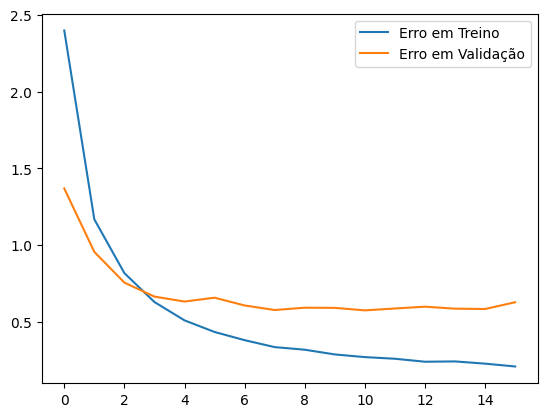

In [43]:
# Plot of error curves
loss, val_loss = history.history['loss'], history.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [46]:
# Predictions with test dataset
predictions = model.predict(test_pad_seq)

# Labels predicteds
predictions_labels = predictions.argmax(axis = 1)

# Printing classification report
print('Classification report')
print(classification_report(y_test_le, predictions_labels))

# Printing confusion matrix
print('Confusion Matrix')
print(confusion_matrix(y_test_le, predictions_labels))

# Printing Accuracy
print('Accuracy')
print(accuracy_score(y_test_le, predictions_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       275
           1       0.84      0.82      0.83       224
           2       0.92      0.92      0.92       695
           3       0.74      0.75      0.75       159
           4       0.93      0.93      0.93       581
           5       0.66      0.68      0.67        66

    accuracy                           0.89      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.89      0.89      0.89      2000

Confusion Matrix
[[244   7   3   5  12   4]
 [ 13 183   6   1   7  14]
 [  2   6 638  33  15   1]
 [  1   3  27 120   6   2]
 [ 15   8  15   0 541   2]
 [  1  11   4   4   1  45]]
Accuracy
0.8855


In [48]:
# Saving the model
model.save('models/model_v2.keras')

## Loading model

In [62]:
# Loading the model
loaded_model = tf.keras.models.load_model('models/model_v2.keras')

# New sentence
sentence = 'I was amazed when she told me that'

# Creating a dataframe with the sentence
df_new = pd.DataFrame({'text': [sentence]})

# Applying processing function
df_new['transformed_text'] = df_new['text'].apply(data_preprocessing)

df_new.head()

,text,transformed_text
0,I was amazed when she told me that,amazed tell


In [63]:
# Processing new data
new_seq = tokenizer.texts_to_sequences(df_new['transformed_text'])
new_pad_seq = pad_sequences(new_seq, maxlen=max_lenght)

# Predictions with loaded model
prediction = model.predict(new_pad_seq)

# Seleciona a classe com maior probabilidade
class_prob = np.argmax(prediction, axis = 1)

# Obtém o nome da classe
class_label = le.inverse_transform(class_prob)

# Class predicted
print(f'The feeling is {class_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
The feeling is ['surprise']


In [64]:
list(df_train['feeling'].unique())

['fear', 'joy', 'anger', 'sadness', 'love', 'surprise']

# The end